<a href="https://colab.research.google.com/github/alice-malivert/Tutorial_transformers/blob/main/Transformers_tutorial_AM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers for image segmentation


## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Oct 24 10:31:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Task and dataset
Segmentating an image means to partition it into different components, based on the objects/parts that make it up. It is a field for which ML makes an incredible difference, for example in biology.

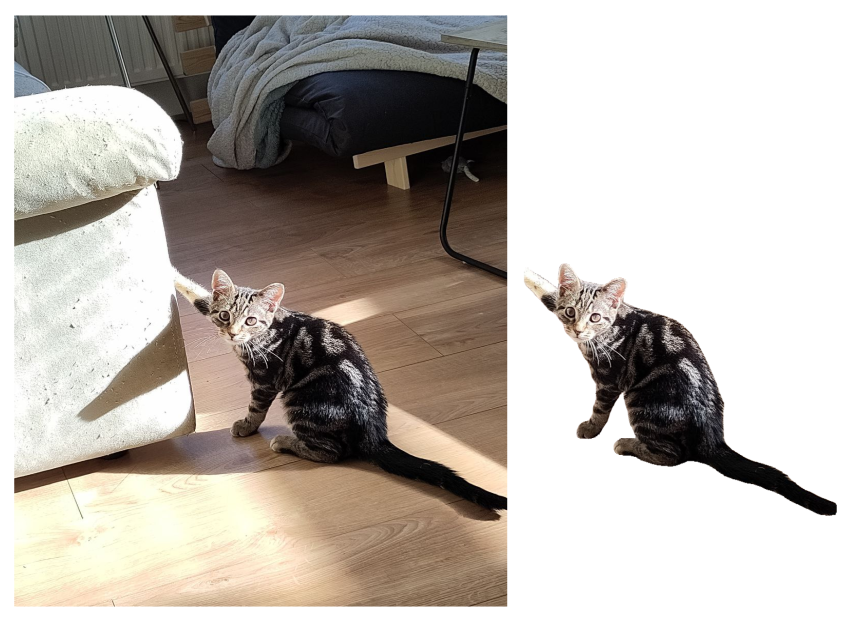

Today we'll segment cats!
Let's import all the images from my github:

In [2]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

api_url = 'https://api.github.com/repos/alice-malivert/Tutorial_transformers/contents/Mousse_pics'
response = requests.get(api_url)

if response.status_code == 200:
    files = response.json()
    file_urls = [file['download_url'] for file in files if file['type'] == 'file']
    print(f"Pictures retrieved")
else:
    print(f"Error: Unable to retrieve files (Status Code: {response.status_code})")

Pictures retrieved


Functions to retrieve and display images from url:

In [3]:
def load_image_from_url(url):
    """
    Loads an image from a URL. Returns BGR, RGB and PIL.
    """
    response = requests.get(url)
    image_bgr = np.asarray(bytearray(response.content), dtype="uint8")
    image_bgr = cv2.imdecode(image_bgr, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Convert to PIL Image
    image_pil = Image.fromarray(image_rgb)

    return image_bgr, image_rgb, image_pil

In [4]:
def plot_from_url(url):
    """
    Display an image from a URL using load_image_from_url.
    """
    image_bgr, image_rgb, image_pil = load_image_from_url(file_urls[0])

    plt.figure(figsize=(8, 8))
    plt.imshow(image_pil)
    plt.axis('off')
    plt.show()

Let's try displaying one:

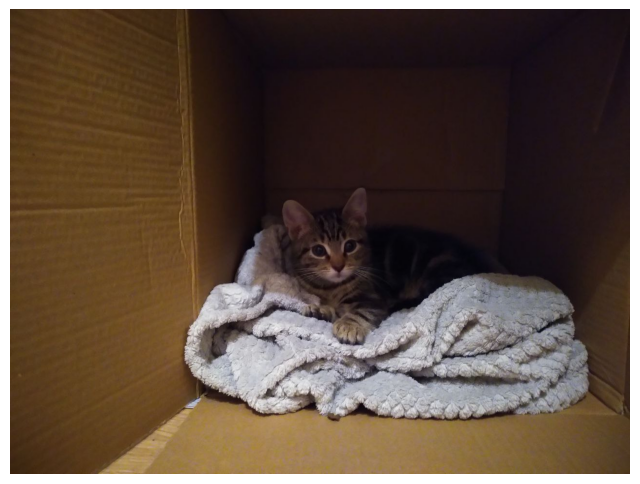

In [5]:
first_image_url = file_urls[0]
plot_from_url(first_image_url)

# The Huggingface transformers library

Huggingface has created a transformers library with different models for several tasks. First, let's install it:

##Set up

In [6]:
%%capture
!pip install -q datasets transformers evaluate accelerate
!pip install timm

You can see that many tasks you would require transformers for (including several computer vision tasks) are part of this library:

In [7]:
from transformers import pipelines
for task in pipelines.SUPPORTED_TASKS:
    print(task)

audio-classification
automatic-speech-recognition
text-to-audio
feature-extraction
text-classification
token-classification
question-answering
table-question-answering
visual-question-answering
document-question-answering
fill-mask
summarization
translation
text2text-generation
text-generation
zero-shot-classification
zero-shot-image-classification
zero-shot-audio-classification
image-classification
image-feature-extraction
image-segmentation
image-to-text
object-detection
zero-shot-object-detection
depth-estimation
video-classification
mask-generation
image-to-image


Let's access my huggingface tokens and set up everything

In [8]:
from google.colab import userdata
import os
from transformers import pipeline
import timm
import torch
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

## Test segmentation


This library can segment everything in an image and return not only masks, but their labels too.

In [9]:
first_image_url = file_urls[0]
image_bgr, image_rgb, image_pil = load_image_from_url(first_image_url)

panoptic_segmentation = pipeline("image-segmentation", "facebook/detr-resnet-50-panoptic",device = 0)
panoptic_segmentation(image_pil)

config.json:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/172M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

`label_ids_to_fuse` unset. No instance will be fused.


[{'score': 0.979218,
  'label': 'LABEL_199',
  'mask': <PIL.Image.Image image mode=L size=1280x960>},
 {'score': 0.955547,
  'label': 'LABEL_186',
  'mask': <PIL.Image.Image image mode=L size=1280x960>},
 {'score': 0.998374,
  'label': 'cat',
  'mask': <PIL.Image.Image image mode=L size=1280x960>},
 {'score': 0.950805,
  'label': 'window-blind',
  'mask': <PIL.Image.Image image mode=L size=1280x960>}]

## Batch segmentation
I am now building functions to segment everything in my images, classify the objects and return the cat as a mask overlaying the original image. I want to batch this over all the functions of my folder.

In [ ]:
def find_masks(image_url):
    """
    Applies image segmentation on the image provided by a URL.
    Returns the list of masks found.
    """
    device = 0 if torch.cuda.is_available() else -1 # for GPU acceleration

    image_bgr, image_rgb, image_pil = load_image_from_url(image_url)

    panoptic_segmentation = pipeline("image-segmentation", "facebook/detr-resnet-50-panoptic", device=device)
    results = panoptic_segmentation(image_pil)
    return results

In [ ]:
def chose_cat_mask(results):
    """
    Selects the masks labelled as cat and returns them as numpy arrays.
    """
    cat_masks = []
    for result in results:
        if result['label'] == 'cat':
            cat_masks.append(result['mask'])
            # Check if 'area' is in the result and print its value if it exists
            if 'area' in result:
                print(f"Found a cat mask for {result['label']} with area {result['area']}")
            else:
                print(f"Found a cat mask for {result['label']} but no area information available.")
    if not cat_masks:
        print("No cat found in the image.")
    return cat_masks


In [ ]:
def plot_cat_mask(cat_mask, image_url):
    """
    Plots the mask from cat_mask as a blue transparent overlay over the image from image_url.
    """

    image_bgr, image_rgb, image_pil = load_image_from_url(image_url)
    mask_array = np.array(cat_mask)
    blue_overlay = np.zeros((mask_array.shape[0], mask_array.shape[1], 4), dtype=np.uint8)
    blue_overlay[:, :, 2] = 255
    blue_overlay[:, :, 3] = mask_array * 128

    blue_overlay_img = Image.fromarray(blue_overlay)
    image_with_overlay = Image.alpha_composite(image_pil.convert("RGBA"), blue_overlay_img)

    # Display the image with overlay
    plt.figure(figsize=(8, 8))
    plt.imshow(image_with_overlay)
    plt.axis('off')
    plt.show()

In [ ]:
def batch_images(file_urls, indices=None):
    """
    Calculates and plots as overlay the masks of the cat found in each picture of dataset_folder.
    Users can specify which images to process by providing a list of indices.
    """

    if indices is None:
        indices = range(len(file_urls))

    for i in indices:
        image_url = file_urls[i]

        masks = find_masks(image_url)
        cat_masks = chose_cat_mask(masks)

        if cat_masks:
            for cat_mask in cat_masks:
                plot_cat_mask(cat_mask, image_url)

##Application

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Found a cat mask for cat but no area information available.


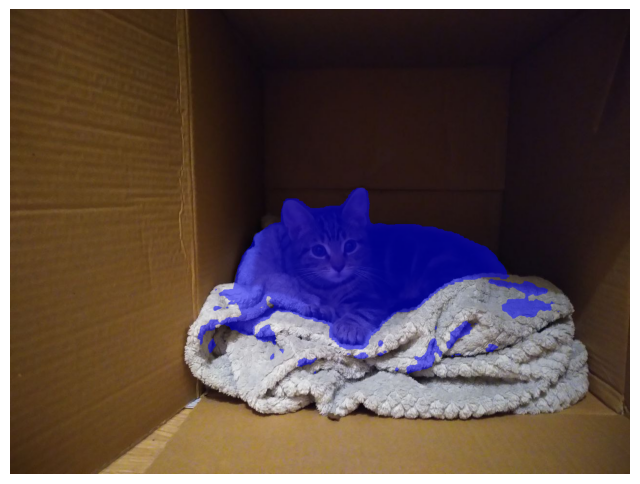

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Found a cat mask for cat but no area information available.


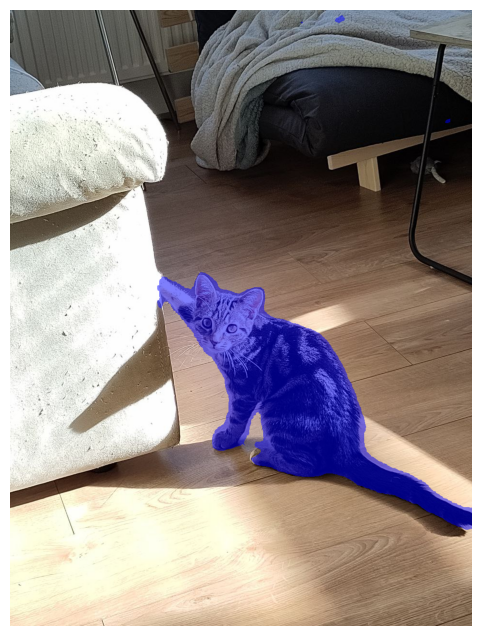

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Found a cat mask for cat but no area information available.


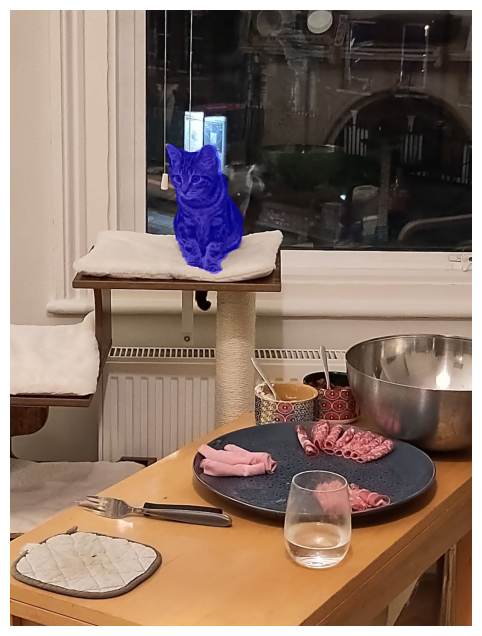

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Found a cat mask for cat but no area information available.


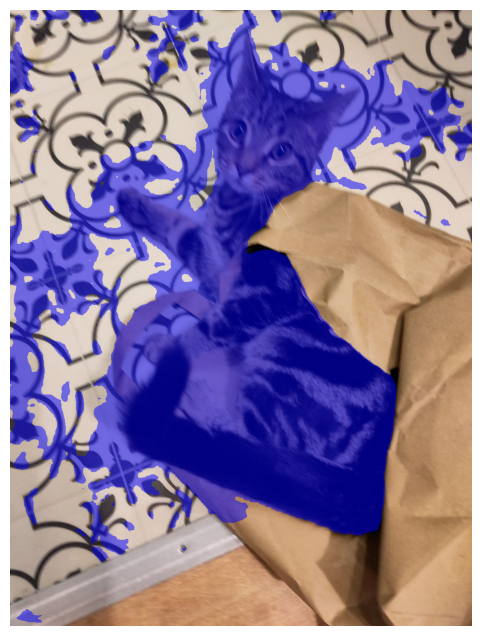

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Found a cat mask for cat but no area information available.
Found a cat mask for cat but no area information available.


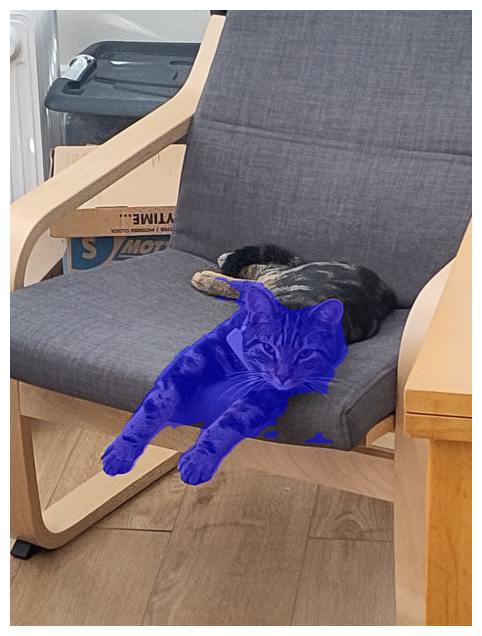

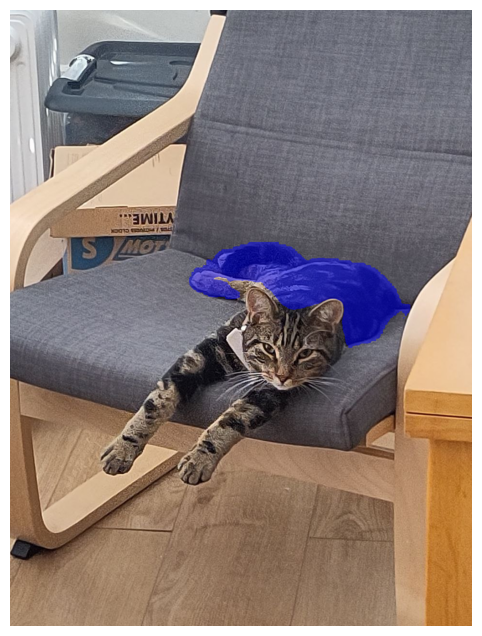

In [ ]:
batch_images(file_urls,range(0,5))

We can see that some of the images are well-segmented while others are not. Sometimes they add some non-cat to the segmentation, sometimes they forget about cat parts, sometimes they segment the whole cat in two masks (that one is not a big deal).

Let's try a more general (foundation?) model.

# The Segment Anything Model

Meta has developped a zero-shot segmentation model, i.e. a model which they argue can be used on any image to segment any object without further training.


## Set up

First, let's install the model:

In [10]:
%%capture
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

In [11]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


Download SAM weights:

In [12]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [13]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


Load model:

In [14]:
import torch
import supervision as sv

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [15]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

## Test segmentation
Let's try it with an image:

In [16]:
first_image_url = file_urls[0]
image_bgr, image_rgb, image_pil = load_image_from_url(first_image_url)

sam_result = mask_generator.generate(image_rgb)
sam_result

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 119610,
  'bbox': [282, 790, 997, 167],
  'predicted_iou': 1.0147958993911743,
  'point_coords': [[1180.0, 825.0]],
  'stability_score': 0.9833438396453857,
  'crop_box': [0, 0, 1280, 960]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 183425,
  'bbox': [362, 546, 

## Segmentation functions
I am now building functions to segment everything in my images, classify the objects and return the cat as a mask overlaying the original image. I want to batch this over all the functions of my folder.

This next function is the one doing the actual segmentation:

In [ ]:
def calculate_mask_sam(image_bgr,image_rgb):
  """
  Calculates and plots as overlay the masks found in the picture image_url.
  """
  sam_result = mask_generator.generate(image_rgb) # Uses the SAM to generate a mask

  # Plots
  mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
  detections = sv.Detections.from_sam(sam_result=sam_result)

  annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

  sv.plot_images_grid(
      images=[image_bgr, annotated_image],
      grid_size=(1, 2),
      titles=['Source Image', 'Segmented Image']
  )

In [ ]:
def batch_images_sam(file_urls, indices=None):
    """
    batch calculate_mask_sam on all images in the folder from indices.
    """

    if indices is None:
        indices = range(len(file_urls))

    for i in indices:
      image_bgr, image_rgb, image_pil = load_image_from_url(file_urls[i])

      calculate_mask_sam(image_bgr,image_rgb)

## Application

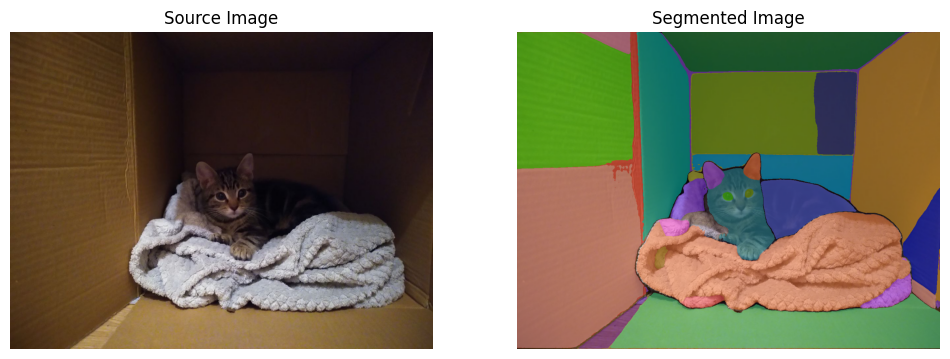

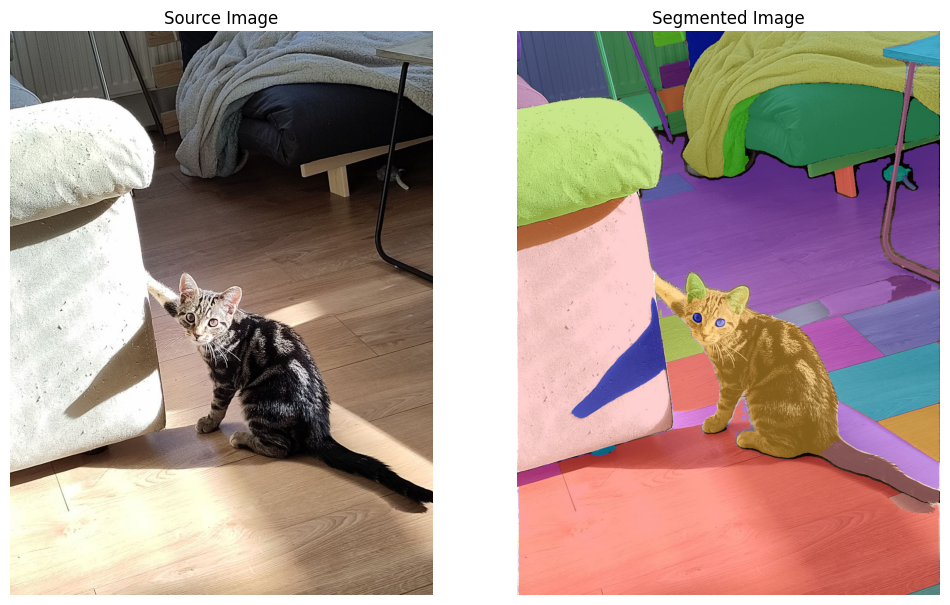

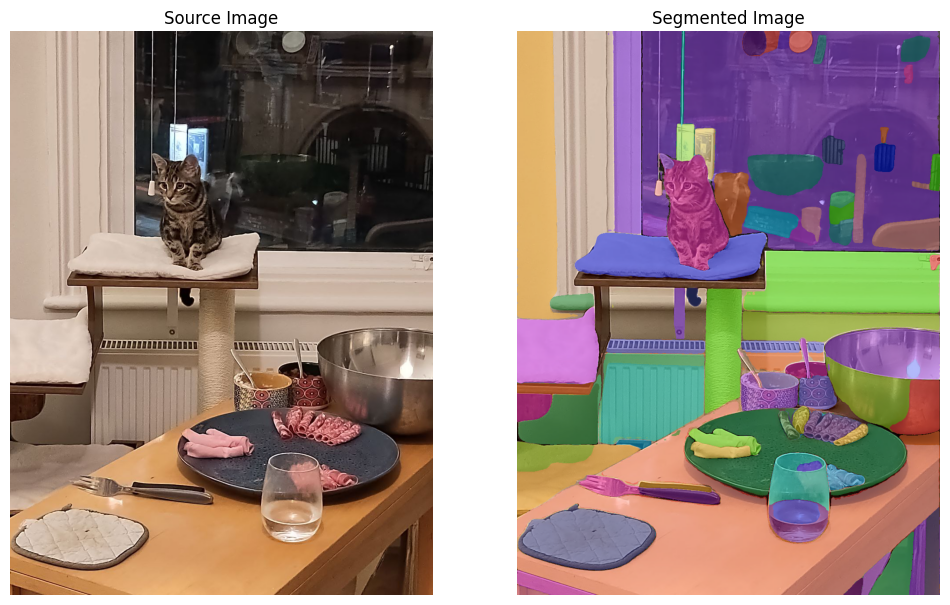

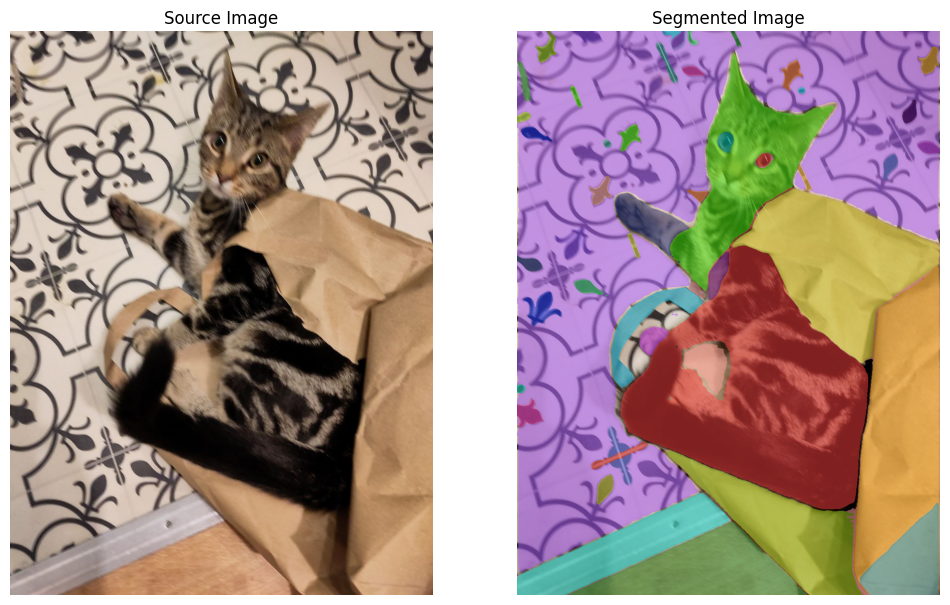

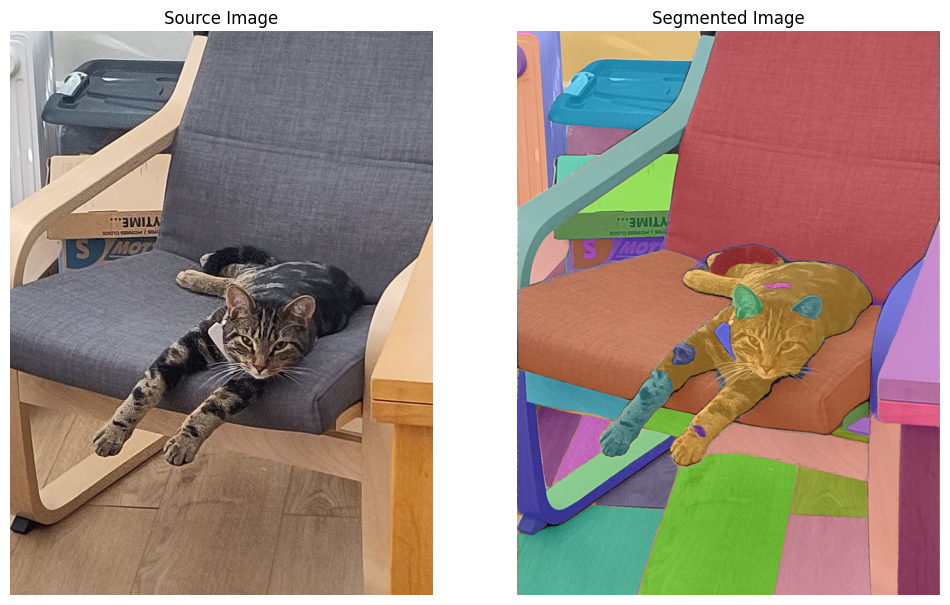

In [ ]:
batch_images_sam(file_urls,range(0,5))

The segmentation is way better: the cat is usually composed of different masks, but they only take cat parts and all parts are covered. By assembling some masks you can obtain a cat mask.

## Prompting

We can add box prompts on the cat to refine the segmentation and only get the cat mask out.


Even though Meta claims in the paper that it can intake a text prompt, the model has not been published with a built-in text prompt input.

Here is a way to combine it with a model generating boxes based on text prompt (the SAM can take box prompts): https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Grounding%20DINO/GroundingDINO_with_Segment_Anything.ipynb.

## Agriculture side note
Even if the SAM scores well on fairness for genders and skin tones, the images the SAM has been trained on still reflect a human bias: plant blindness. Crops and land are often considered as background, especially for drone/satellite images, and as such, they are often badly segmented. See https://doi.org/10.48550/arXiv.2304.05750.

Of course, the SAM as any other model can be refined for a specific task. Here is an example of improvement for segmentation from aerial and satellite images, turning the zero-shot model into a one-shot model: https://doi.org/10.1016/j.jag.2023.103540 .